# 1.0 - Clustering of METABRIC

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch

import os
import sys
sys.path.append(f"../")
from sslcox.utils.model_evaluation import model_already_trained
from sslcox.data.load_datasets import load_METABRIC
from sslcox.metrics.morans_measure import moran_measure, bootstrap_moran_I

In [31]:
EXPRESSIONS = 'METABRIC-clustering'

DS_DIR = f'{EXPRESSIONS}-optuna'
CV_DIR = lambda cv: f'CV-{cv}'
MODEL_DIR = lambda m: f'{m}-model-results'

In [32]:
training_results = []

for cv in sorted(os.listdir(f'../data/training-results/{DS_DIR}')):
    if cv.startswith('.'): continue
    cv_results = {}

    for model in os.listdir(f'../data/training-results/{DS_DIR}/{cv}'):
        if model.startswith('.'): continue

        name = model.split('-model-results')[0]
        base_path = f'../data/training-results/{DS_DIR}/{cv}/{model}'

        if not model_already_trained(DS_DIR, CV_DIR(cv.split('-')[1]), MODEL_DIR(name)):
            continue

        X_train_latent = pd.read_csv(f'{base_path}/X_train_latent.tsv', sep='\t', index_col=['index'])
        #X_test_latent = pd.read_csv(f'{base_path}/X_test_latent.tsv', sep='\t', index_col=['index'])
        
        cv_results[name] = {
            'X_train_latent': X_train_latent,
            #'X_test_latent': X_test_latent,
        }
        
        # IF VAE
        if 'vae' in name:

            with open(f'{base_path}/study.pickle', 'rb') as f:
                study = pickle.load(f)
            torch_weights = torch.load(f'{base_path}/torch_model.pt', map_location=torch.device('cpu'))

            cv_results[name].update({
                'study': study,
                'torch_weights': torch_weights,
            })
    
    training_results += [cv_results]

In [33]:
data, metadata = load_METABRIC()

In [34]:
metadata.head().T

PATIENT_ID,MB-0362,MB-0346,MB-0386,MB-0574,MB-0185
LYMPH_NODES_EXAMINED_POSITIVE,1.0,5.0,8.0,1.0,NaN
NPI,4.036,6.032,6.03,5.042,5.1
CELLULARITY,High,High,Moderate,High,Moderate
CHEMOTHERAPY,YES,NO,NO,NO,NO
COHORT,1.0,1.0,1.0,1.0,1.0
ER_IHC,Positve,Negative,Positve,Positve,Positve
HER2_SNP6,NEUTRAL,GAIN,LOSS,NEUTRAL,GAIN
HORMONE_THERAPY,YES,NO,YES,YES,YES
INFERRED_MENOPAUSAL_STATE,Post,Pre,Post,Post,Post
SEX,Female,Female,Female,Female,Female


In [37]:
from sklearn.manifold import TSNE
clustering_eval_tsne = {}

for k in range(len(training_results)):
    clustering_eval_tsne[k] = {}
    for model, values in training_results[k].items():
        tsne_data = TSNE(init='pca', random_state=1, perplexity=50).fit_transform(values['X_train_latent'])
        clustering_eval_tsne[k][model] = {
            'tsne_data': tsne_data,
            'claudin_subtype': metadata.loc[values['X_train_latent'].index, 'CLAUDIN_SUBTYPE'].fillna('Unknown'),
            'THREEGENE': metadata.loc[values['X_train_latent'].index, 'THREEGENE'].fillna('Unknown'),
        }

In [40]:
clustering_eval_claudin = {}
for name in training_results[0].keys():
    clustering_eval_claudin[name] = []
    
    for k in range(len(training_results)):

        labels = np.array([list(np.unique(clustering_eval_tsne[k][name]['claudin_subtype'])).index(x) for x in clustering_eval_tsne[k][name]['claudin_subtype']])

        clustering_eval_claudin[name] = bootstrap_moran_I(clustering_eval_tsne[k][name]['tsne_data'], labels, M=100)

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


In [41]:
for name, val in clustering_eval_claudin.items():
    print(name, f' & \({val[0]:.3f} \pm {val[2]:.3f}\)')

vae-mse  & \(0.342 \pm 0.002\)
vae-cox  & \(0.413 \pm 0.002\)
pca-emb  & \(0.462 \pm 0.002\)
vae-div  & \(0.304 \pm 0.002\)
no-embedding  & \(0.412 \pm 0.002\)


In [43]:
for name, val in clustering_eval_claudin.items():
    print(name, ', '.join([f'{x:.3f}' for x in val]))

vae-mse 0.342, 0.020, 0.002
vae-cox 0.413, 0.020, 0.002
pca-emb 0.462, 0.021, 0.002
vae-div 0.304, 0.020, 0.002
no-embedding 0.412, 0.021, 0.002


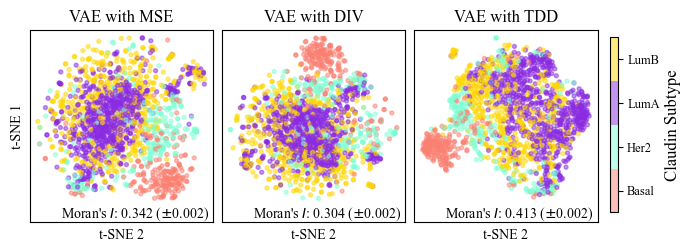

In [44]:
from matplotlib.colors import LinearSegmentedColormap

label_dict = {
    'pca-emb': 'PCA embedding',
    'vae-mse': 'VAE with MSE',
    'vae-div': 'VAE with DIV',
    'vae-cox': 'VAE with TDD'
}

colors = ["#FA8072",  # Salmon
          "#7FFFD4",  # Aquamarine
          "#8A2BE2",  # Blue violet
          "#FFD700"]  # Gold
pastel_cmap = LinearSegmentedColormap.from_list("pastel_cmap", colors, N=4)

plt.rcParams["font.family"] = "Times New Roman"
f, ax = plt.subplots(1, 3, figsize=(8, 2.5), gridspec_kw={'hspace':0.05, 'wspace':0.05})

process = 'claudin_subtype'
process_label = 'Claudin Subtype'
ID = 0
tsne_space = clustering_eval_tsne[ID]
cluster_labels = np.unique(tsne_space['pca-emb'][process])
for i, name in enumerate(['vae-mse', 'vae-div', 'vae-cox']):
    cmap = ax[i].scatter(
        tsne_space[name]['tsne_data'][:,0], tsne_space[name]['tsne_data'][:,1],
        c=[list(cluster_labels).index(x) for x in tsne_space[name][process]],
        alpha=0.5, s=8, cmap='YlOrBr' if process == 'transcription' else pastel_cmap
    )

    ax[i].set_xticks([])
    ax[i].set_yticks([])

    ax[i].set_title(label_dict[name], fontsize=12)
    if i == 0: ax[i].set_ylabel('t-SNE 1', fontsize=10)
    ax[i].set_xlabel('t-SNE 2', fontsize=10)

    ylim = ax[i].get_ylim()
    xlim = ax[i].get_xlim()
    ax[i].set_ylim(bottom=ylim[0]*1.2)
    ax[i].text(xlim[1], ylim[0]*1.2,
               f"Moran's $I$: {clustering_eval_claudin[name][0]:.3f} (" + r"$\pm$"+ f"{clustering_eval_claudin[name][2]:.3f})  ",
               va='bottom', ha='right', fontsize=10)

    if i == 2:

        f.subplots_adjust(right=0.835)
        cbar_ax = f.add_axes([0.85, 0.15, 0.01, 0.7])  # Adjust the [left, bottom, width, height] as needed
        cb = f.colorbar(cmap, cax=cbar_ax)

        cb.set_label(process_label, fontsize=12)
        cb.set_ticks(np.arange(0,12,3)/4 + 3/8, labels=cluster_labels, fontsize=9)

f.savefig(f'../figures/METABRIC_clustering.pdf', dpi=300, bbox_inches='tight')